<a href="https://colab.research.google.com/github/luluoddish/DS-Coding/blob/main/Amazon%20Food%20Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [51]:
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [52]:
print('The data set has {} rows and {} columns'.format(df.shape[0],df.shape[1]))

The data set has 568454 rows and 10 columns


In [53]:
df.nunique() # check num of unique items per column

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

In [54]:
df.info()#check missing values and data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


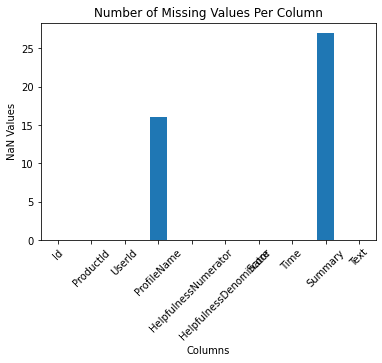

In [55]:
df.isnull().sum().plot(kind='bar')
plt.title('Number of Missing Values Per Column')
plt.xticks(rotation = 45)
plt.xlabel("Columns")
plt.ylabel("NaN Values");

In [56]:
df.dropna(inplace=True)

In [57]:
df.duplicated().sum()#check whether Duplicated

0

In [58]:
df["Sentiment"] = df["Score"].apply(lambda score: 1 if score > 3 else 0)
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [59]:
print(df['Sentiment'].value_counts())

1    443766
0    124645
Name: Sentiment, dtype: int64


In [60]:
df = df[["Score", "Sentiment", "Summary", "Text"]]

In [61]:
df[df.Score == 5].head()

,Score,Sentiment,Summary,Text
0,5,1,Good Quality Dog Food,I have bought several of the Vitality canned d...
4,5,1,Great taffy,Great taffy at a great price. There was a wid...
6,5,1,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,5,1,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,5,1,Yay Barley,Right now I'm mostly just sprouting this so my...


In [62]:
df[df.Score == 1].head()

,Score,Sentiment,Summary,Text
1,1,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
12,1,0,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...
26,1,0,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
50,1,0,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
62,1,0,stale product.,Arrived in 6 days and were so stale i could no...


**Cleaning the Data**
- Stop words removal (commonly used word (such as “the”, “a”, “an”, “in”) )
- Stemming
- Punctuations
- Lowering

In [63]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [64]:
'not' in stop

True

Stemming

In [65]:
from nltk.stem import SnowballStemmer 
# Stemmers remove morphological affixes from words, leaving only the word stem.
snow = SnowballStemmer('english') 
print(snow.stem('tasty'))
print(snow.stem('joined'))
print(snow.stem('apples'))

tasti
join
appl


### Punctuations Removal

In [66]:
import re
# cleaning punctuations from the sentence
sentence = "I'd like to have some coffee today!"
sentence = re.sub(r'[\'|"|#]', r'', sentence) # remove these punctuation
sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
sentence

'Id like to have some coffee today '

In [67]:
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # lower case
    sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
    tokens = sentence.split()
    out = []
    for t in tokens:
        out.append(snow.stem(t))
    out = " ".join(out)
    out = re.sub(r'[\'|"|#]', r'', out) # remove these punctuation
    return out   

In [68]:
df["Summary_Clean"] = df["Summary"].apply(cleanup)

In [69]:
df.head()

,Score,Sentiment,Summary,Text,Summary_Clean
0,5,1,Good Quality Dog Food,I have bought several of the Vitality canned d...,good qualiti dog food
1,1,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,not as advertis
2,4,1,"""Delight"" says it all",This is a confection that has been around a fe...,delight say it all
3,2,0,Cough Medicine,If you are looking for the secret ingredient i...,cough medicin
4,5,1,Great taffy,Great taffy at a great price. There was a wid...,great taffi


**Train-Test-Split**

In [70]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Summary_Clean'], df['Sentiment'], random_state = 0)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)


X_train first entry: 

 good qualiti dog food


X_train shape:  (426308,)


In [103]:
y_train.value_counts()

1    332913
0     93395
Name: Sentiment, dtype: int64

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
bi_gram = CountVectorizer(ngram_range=(1,2), min_df = 5, binary = True) # 1 means the minimum is unigram, 2 means max is bigrams, 
bi_gram_vectors_train = bi_gram.fit_transform(X_train)
bi_gram_vectors_test = bi_gram.transform(X_test)

In [72]:
bi_gram_vectors_train.shape

(426308, 44718)

In [73]:
features = bi_gram.get_feature_names()
features[-10:]

['zuke',
 'zuke chicken',
 'zuke dad',
 'zuke dog',
 'zuke hip',
 'zuke is',
 'zuke mini',
 'zuke peanut',
 'zuke salmon',
 'zuke treat']

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5)
tfidf_vectors_train = tfidf.fit_transform(X_train)
tfidf_vectors_test = tfidf.transform(X_test)

In [75]:
tfidf_vectors_train.shape

(426308, 44718)

In [76]:
features = tfidf.get_feature_names()
features[-10:]

['zuke',
 'zuke chicken',
 'zuke dad',
 'zuke dog',
 'zuke hip',
 'zuke is',
 'zuke mini',
 'zuke peanut',
 'zuke salmon',
 'zuke treat']

## **Model Building+Model Evaluation**

# **Logistic Regression**

In [77]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(bi_gram_vectors_train, y_train)

LogisticRegression()

In [79]:
from sklearn.metrics import roc_auc_score
predictions = lr.predict(bi_gram_vectors_test)
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.8557079713133608


In [80]:
cm = confusion_matrix( y_test, predictions.round())
print(cm)

[[ 23228   8022]
 [  3534 107319]]


In [82]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
print(accuracy_score(y_test, predictions.round()))
print(precision_score(y_test, predictions.round()))
print(recall_score(y_test, predictions.round()))
print(f1_score(y_test, predictions.round()))

0.9186787048830778
0.9304497099903764
0.9681199426267219
0.9489111117005755


In [85]:
pre_y = lr.predict_proba(bi_gram_vectors_test)

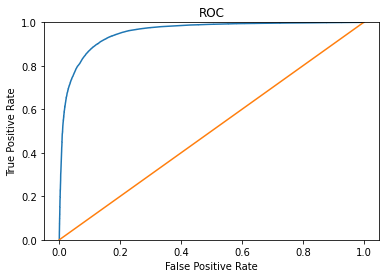

In [88]:
fpr, tpr, thresholds = roc_curve(y_test, pre_y[:,1])
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [95]:
feature = bi_gram.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(feature, lr.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

,feature,coef
44445,yuck,-5.291228
10923,disgust,-4.857768
43758,worst,-4.815615
19251,horribl,-4.639011
25866,nasti,-4.427992
...,...,...
42665,what not,4.477716
26413,no bitter,4.608018
26725,not bitter,4.842162
26710,not bad,5.170211


In [89]:
lr_tfidf = LogisticRegression()
lr_tfidf.fit(tfidf_vectors_train, y_train)

LogisticRegression()

In [90]:
predictions = lr_tfidf.predict(tfidf_vectors_test)
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.8446465161610421


In [91]:
cm = confusion_matrix( y_test, predictions.round())
print(cm)

[[ 22522   8728]
 [  3482 107371]]


In [92]:
print(accuracy_score(y_test, predictions.round()))
print(precision_score(y_test, predictions.round()))
print(recall_score(y_test, predictions.round()))
print(f1_score(y_test, predictions.round()))

0.9140764093650381
0.9248227805579721
0.9685890323220842
0.9462000775494378


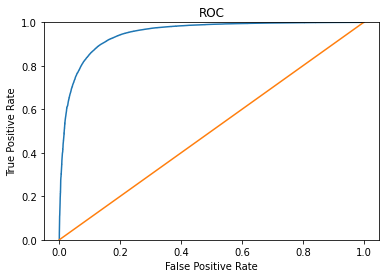

In [93]:
pre_y = lr.predict_proba(tfidf_vectors_test)
fpr, tpr, thresholds = roc_curve(y_test, pre_y[:,1])
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [94]:
feature = tfidf.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(feature, lr_tfidf.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

,feature,coef
26678,not,-11.528789
43758,worst,-9.858866
37457,terribl,-8.550280
19251,horribl,-8.511813
30329,poor,-8.133500
...,...,...
27054,not too,8.739429
12563,excel,10.083642
26710,not bad,11.419398
17156,great,11.983628


# **Random Forest**

In [104]:
from sklearn.ensemble import RandomForestClassifier
#build the model
rf = RandomForestClassifier(n_estimators=100,n_jobs = -1,oob_score=True)
rf.fit(bi_gram_vectors_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True)

In [109]:
predictions = rf.predict(bi_gram_vectors_test)
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.8842604121855069


In [110]:
cm = confusion_matrix( y_test, predictions.round())
print(cm)

[[ 25189   6061]
 [  4160 106693]]


In [111]:
print(accuracy_score(y_test, predictions.round()))
print(precision_score(y_test, predictions.round()))
print(recall_score(y_test, predictions.round()))
print(f1_score(y_test, predictions.round()))

0.9280732989451314
0.9462458094613051
0.9624728243710139
0.9542903397478613


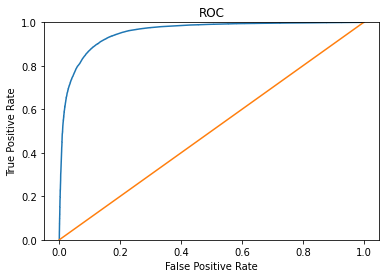

In [112]:
pre_y = lr.predict_proba(bi_gram_vectors_test)
fpr, tpr, thresholds = roc_curve(y_test, pre_y[:,1])
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [113]:
feature = bi_gram.get_feature_names()
rf_feature_importance = pd.DataFrame(data = list(zip(feature, rf.feature_importances_)),
    columns = ['feature', 'importance'])
rf_feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
26678,not,0.045810
10868,disappoint,0.017165
17156,great,0.014501
5897,but,0.008359
3309,bad,0.008218
...,...,...
15119,formula work,0.000000
4745,between snack,0.000000
26654,noodl meal,0.000000
35881,strongest aroma,0.000000
